In [1]:
import time
import numpy as np
import re
import pandas as pd
from collections import OrderedDict
from datetime import datetime as dt, timedelta
import pytz
import seaborn as sns
import matplotlib.pyplot as plt 

#Model libraries
!pip install prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
# from IPython.display import display

!pip install -U kaleido
#Evaluation & HP Tuning
!pip install optuna 
import optuna  # pip install optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

  Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl.metadata (15 kB)
Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl (65.9 MB)
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached greenlet-3.0.3-cp310-cp310-win_amd64.whl.metadata (3.9 kB)
Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.1 MB 544.7 kB/s eta 0:00:04
   -------- ------------------------------- 0.4/2.1 MB 3.1 MB/s eta 0:00:01
   -------------------------------------- - 2.0/2.1 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB

In [2]:
#Read in dataset
df = pd.read_csv('../final_data.csv')
df['date_reported'] = pd.to_datetime(df['date_reported'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['ZIP_Code'] = df['ZIP_Code'].astype('int').astype('str')

# Hyperparameter Tune

In [178]:
#Function to train test split
def evaluate_data(df, zip_code):
    df_prophet = df.copy().rename(columns={"incident_date":"ds"})
    df_prophet.set_index("ds", inplace=True)

    monthly_crime_counts = df_prophet.groupby('ZIP_Code').resample('M').size()
    monthly_crime_counts = monthly_crime_counts.rename('y').reset_index()
    model_df = monthly_crime_counts[monthly_crime_counts['ZIP_Code'] == zip_code]

    t_index = round(len(model_df)*0.7)

    train = model_df[:t_index]
    val = model_df[t_index:-int((len(model_df) - t_index)/2)]
    test = model_df[-len(val)+1:]

    return train, val, test

#Call function for zip code 22202 - highest density zipcode overall
train, val, test = evaluate_data(df, '22202')

In [179]:
#Define optuna function with search grid
def objective(trial, train, val):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        #'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }
    
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.fit(train)
    preds = m.predict(val[['ds']])
    
    #mae_score = mean_absolute_error(val['y'], preds['yhat'])
    mape = mean_absolute_percentage_error(val['y'], preds['yhat'])
    
    return mape

In [180]:
#Create study and run trials
study = optuna.create_study(direction="minimize", study_name="FBProphet - Zip 22202 Crime")
func = lambda trial: objective(trial, train, val)
study.optimize(func, n_trials=1000)

[I 2024-04-21 15:10:58,253] A new study created in memory with name: FBProphet - Zip 22202 Crime
15:10:58 - cmdstanpy - INFO - Chain [1] start processing
15:11:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-21 15:11:00,356] Trial 0 finished with value: 0.21515451401620564 and parameters: {'changepoint_prior_scale': 0.9535155711902142, 'changepoint_range': 0.8412252048172218, 'seasonality_prior_scale': 8.256742659199993, 'holidays_prior_scale': 2.5571737187856707, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': 8, 'yearly_seasonality': 11}. Best is trial 0 with value: 0.21515451401620564.
15:11:00 - cmdstanpy - INFO - Chain [1] start processing
15:11:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-21 15:11:01,877] Trial 1 finished with value: 0.1697285082943306 and parameters: {'changepoint_prior_scale': 2.9392855426370184, 'changepoint_range': 0.806766025522656, 'seasonality_prior_scale': 0.36354076238856503, 'holidays_prior_scale': 9.407934574131

KeyboardInterrupt: 

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\3324289224.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

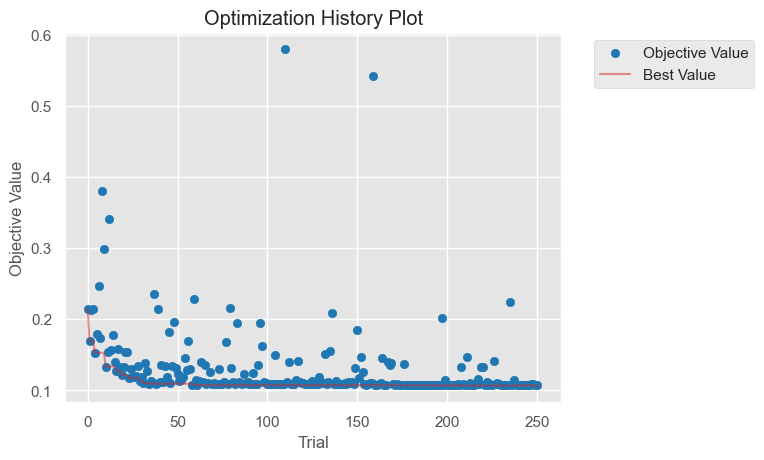

In [181]:
plot_optimization_history(study)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\3836449081.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

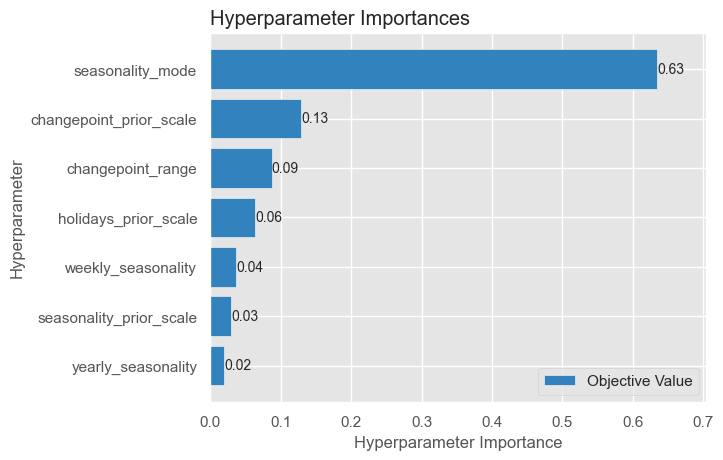

In [182]:
plot_param_importances(study)

In [183]:
#Best params using MAPE
print(study.best_value)
study.best_params

0.10692337779713475


{'changepoint_prior_scale': 4.996475664138592,
 'changepoint_range': 0.8890031218567486,
 'seasonality_prior_scale': 0.8227345812003487,
 'holidays_prior_scale': 2.526746266237134,
 'seasonality_mode': 'additive',
 'weekly_seasonality': 7,
 'yearly_seasonality': 13}

In [184]:
#Test
best_params = study.best_params

concat_df = pd.concat([train, val])

m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.fit(concat_df)
preds = m.predict(test[['ds']])
    
print(mean_absolute_percentage_error(test['y'], preds['yhat']))
print(mean_absolute_error(test['y'], preds['yhat']))

15:18:17 - cmdstanpy - INFO - Chain [1] start processing
15:18:18 - cmdstanpy - INFO - Chain [1] done processing


0.16068007762325168
24.894732811376656


# Forecast

In [185]:

#def prophet_forecast(df, autoregressive_weight, zip_code, crime, periods:int):

def prophet_forecast(df, params, zip_code, crime, periods:int):
    """ 
    This function uses Facebook's Prophet time series forecasting algorithm to
    predict the number of crimes that will be committed in a given zip code.
    
    Inputs:
    - df: DataFrame containing crime data, with columns 'date_reported' (datetime), 'zip' (str), and any additional columns.
    - autoregressive_weight: Numeric value representing the changepoint prior scale for Prophet. Higher values make the forecast more flexible.
    - zip_code: String representing the zip code for which the forecast will be made.
    
    Returns:
    - fig_forecast: Plotly figure object displaying the forecast.
    - fig_components: Plotly figure object displaying the forecast components.
    """
    # Initialize Prophet model
    # m = Prophet(changepoint_prior_scale=autoregressive_weight)
    m = Prophet(**params)
    
    # Prepare the DataFrame for Prophet
    #df_prophet = df.copy().rename(columns={"date_reported":"ds"})
    df_prophet = df.copy().rename(columns={"incident_date":"ds"})
    df_prophet.set_index("ds", inplace=True)
    if crime == 'all':
        df_prophet = df_prophet
    else:
        df_prophet = df_prophet[df_prophet['CategoryCode']==crime]

    monthly_crime_counts = df_prophet.groupby('ZIP_Code').resample('M').size()
    monthly_crime_counts = monthly_crime_counts.rename('y').reset_index()
    model_df = monthly_crime_counts[monthly_crime_counts['ZIP_Code'] == zip_code]
    
    # Fit the model
    m.fit(model_df)
    
    # Make future dataframe
    future = m.make_future_dataframe(periods=periods, freq='M')
    
    # Make predictions
    forecast = m.predict(future)
    
    # Plot forecast and components
    fig_forecast = plot_plotly(m, forecast)
    fig_components = plot_components_plotly(m, forecast)

    #Merge actual and forecasted data manually to visualize via seaborn
    actual = model_df['y'].reset_index().drop(columns='index')
    
    fcst = pd.merge(forecast, actual, how='left', right_index=True, left_index=True)
    
    return fcst, fig_forecast, fig_components

In [186]:
def visualize_plots(df, zip, periods):
    fcst_long = df[['ds', 'yhat_upper', 'yhat_lower', 'yhat', 'y']].melt(id_vars=['ds'], var_name = 'variable', value_name='value')

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(10, 6))

    # Plot 'one' as points
    sns.scatterplot(x='ds', y='value', color='black', style='variable', markers={'y': 'o'}, data=fcst_long.query("variable == 'y'"))

    # Plot 'two' as a line
    sns.lineplot(x='ds', y='value', hue='variable', style='variable', dashes=False, data=fcst_long.query("variable == 'yhat'"))

    sns.lineplot(x='ds', y='value', color='lightblue', style='variable', dashes={'yhat_lower': (5, 5), 'yhat_upper': (5, 5)}, data=fcst_long.query("variable in ['yhat_lower', 'yhat_upper']"))

    plt.fill_between(fcst_long[fcst_long['variable'] == 'yhat_lower']['ds'], 
                    fcst_long[fcst_long['variable'] == 'yhat_lower']['value'], 
                    fcst_long[fcst_long['variable'] == 'yhat_upper']['value'], 
                    color='lightblue', alpha=0.4)
    
    # Set title and labels
    plt.title(f'{periods} Month Forecst for Zip {zip}')
    plt.xlabel('Date')
    plt.ylabel('Crime Density')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(loc='upper left')

    plt.show()

In [187]:
def plot_trends(fcst):
    yearly = fcst.copy()
    yearly['month'] = yearly['ds'].dt.month
    yearly['monthname'] = yearly['ds'].dt.month_name()
    yearly = yearly.groupby(['monthname', 'month'])['yearly'].median().reset_index().sort_values(['month'])

    weekly = fcst.copy()
    weekly['dow'] = weekly['ds'].dt.dayofweek
    weekly['downame'] = np.select([(weekly['dow'] == 0),
                                (weekly['dow'] == 1),
                                (weekly['dow'] == 2),
                                (weekly['dow'] == 3),
                                (weekly['dow'] == 4),
                                (weekly['dow'] == 5),
                                (weekly['dow'] == 6)], 

                                ['Monday', 'Tuesday', 'Wednesday', 
                                'Thursday', 'Friday', 'Saturday', 'Sunday'], 

                                default=np.nan)

    weekly = weekly.groupby(['downame', 'dow'])['weekly'].median().reset_index().sort_values(['dow'])

    trend = fcst.copy()

    sns.set_theme(style="darkgrid")

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

    # Plot line graphs on each subplot
    sns.lineplot(x='ds', y='trend', data=trend, ax=axes[0])
    sns.lineplot(x='monthname', y='yearly', data=yearly, ax=axes[1])
    sns.lineplot(x='downame', y='weekly', data=weekly, ax=axes[2])

    # Set titles for each subplot
    axes[0].set_title('Trend')
    axes[1].set_title('Yearly Seasonality')
    axes[2].set_title('Weekly Seasonality')

    # Adjust layout
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.tight_layout()

    # Show plot
    plt.show()

In [144]:
#Check top zip code with most data to monitor final forecasting performance
df_prophet = df.copy().rename(columns={"incident_date":"ds"})
df_prophet.set_index("ds", inplace=True)
grouped = df_prophet.groupby('ZIP_Code').resample('M').size()
grouped.rename('y').reset_index().groupby(['ZIP_Code']).sum()['y'].reset_index().sort_values(['y'], ascending=False).head(4)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1209805566.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,ZIP_Code,y
10,22202,8957
12,22204,6729
9,22201,6713
11,22203,4969


15:19:26 - cmdstanpy - INFO - Chain [1] start processing


15:19:27 - cmdstanpy - INFO - Chain [1] done processing


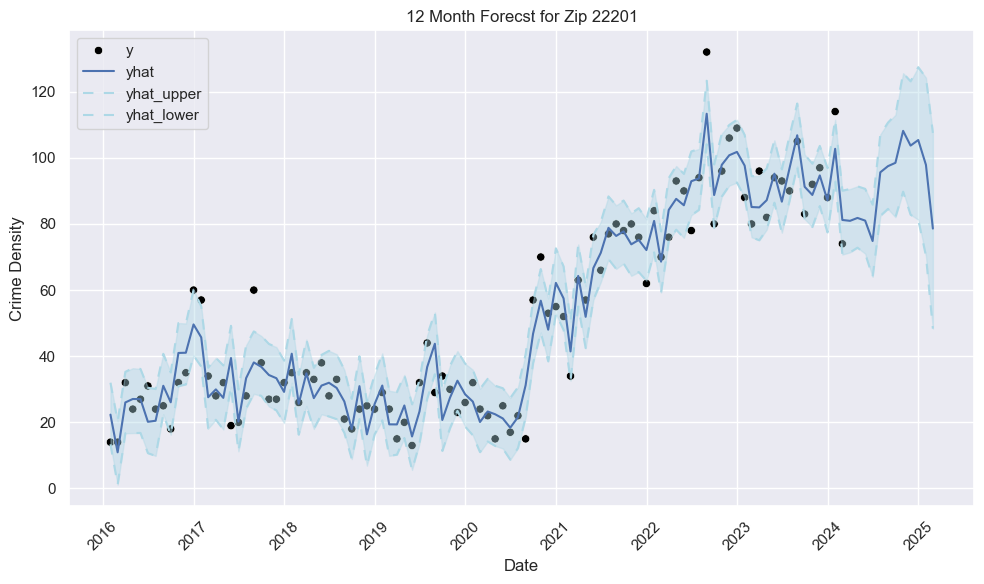

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



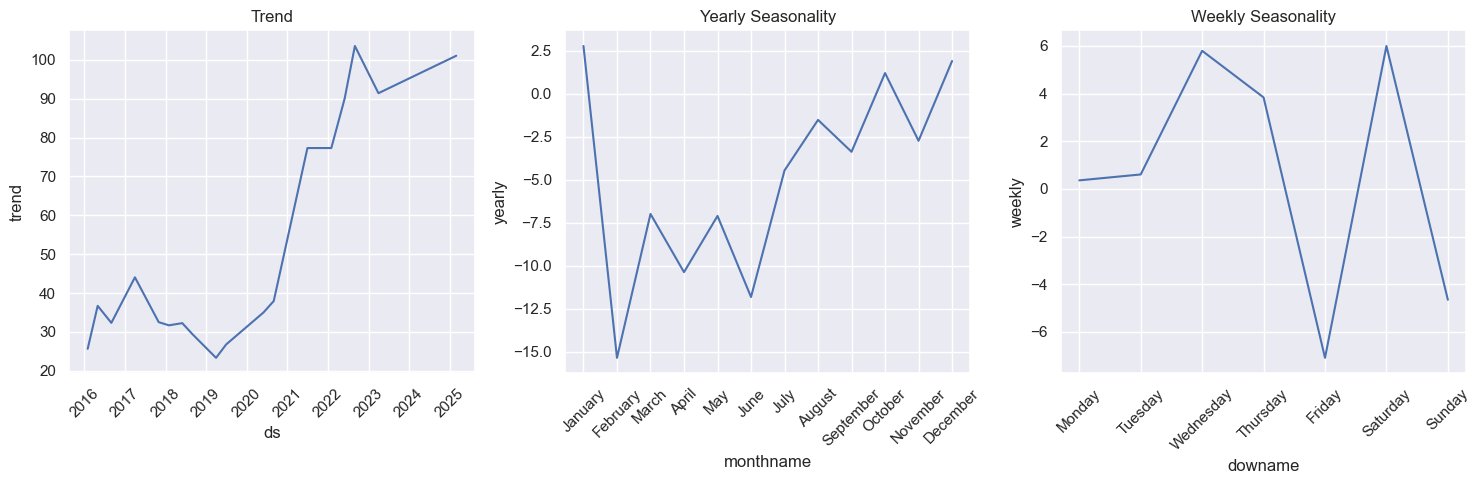

In [188]:
#Forecast zip code 22201
periods = 12
crime = 2
zip_code = '22201'

#fig_forecast & fig_components built in plotly plots won't render in github**
fcst, fig_forecast, fig_components = prophet_forecast(df, 
                                                # autoregressive_weight=0.5, 
                                                best_params,
                                                zip_code=zip_code,
                                                crime=crime,
                                                periods=periods)

visualize_plots(fcst, zip_code, periods)
plot_trends(fcst)

15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing


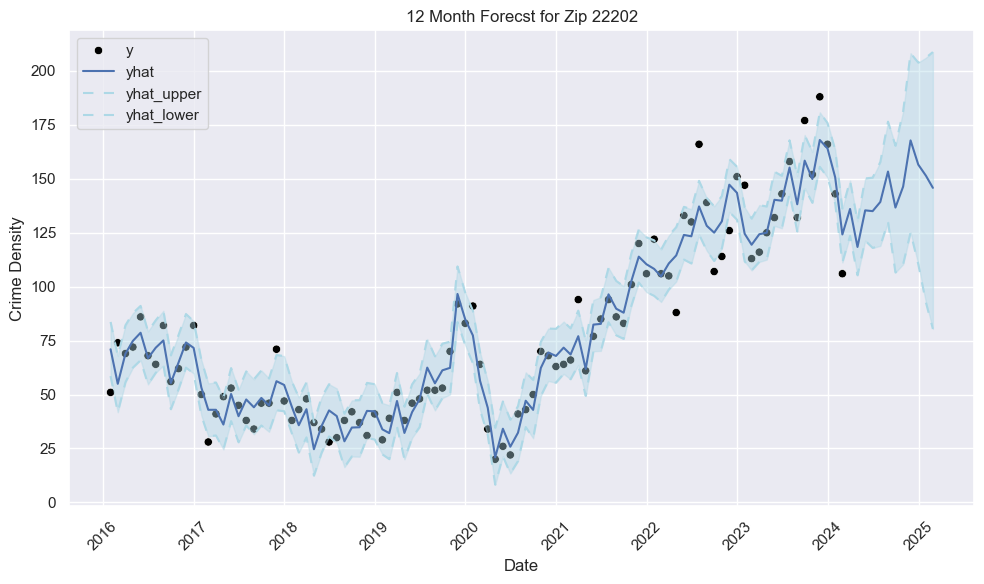

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



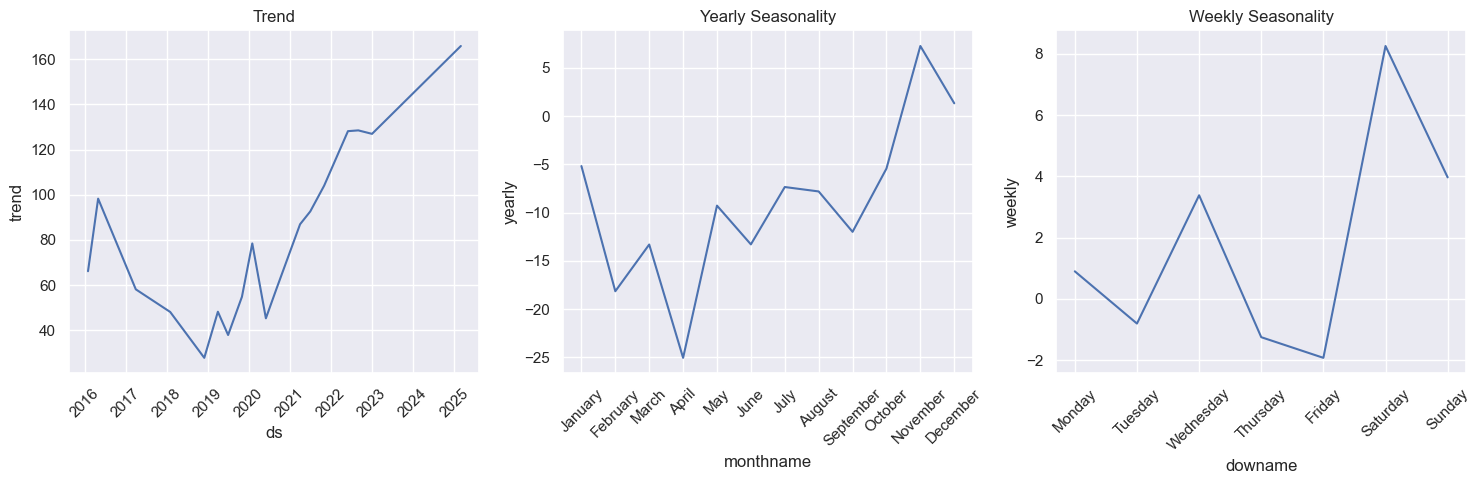

In [189]:
#Forecast zip code 22202
periods = 12
crime = 2
zip_code = '22202'

#Forecast 22202
fcst, fig_forecast, fig_components = prophet_forecast(df, 
                                                best_params,
                                                zip_code='22202',
                                                crime=2,
                                                periods=12)

# Display the forecast plot
visualize_plots(fcst, zip_code, periods)
plot_trends(fcst)

15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing


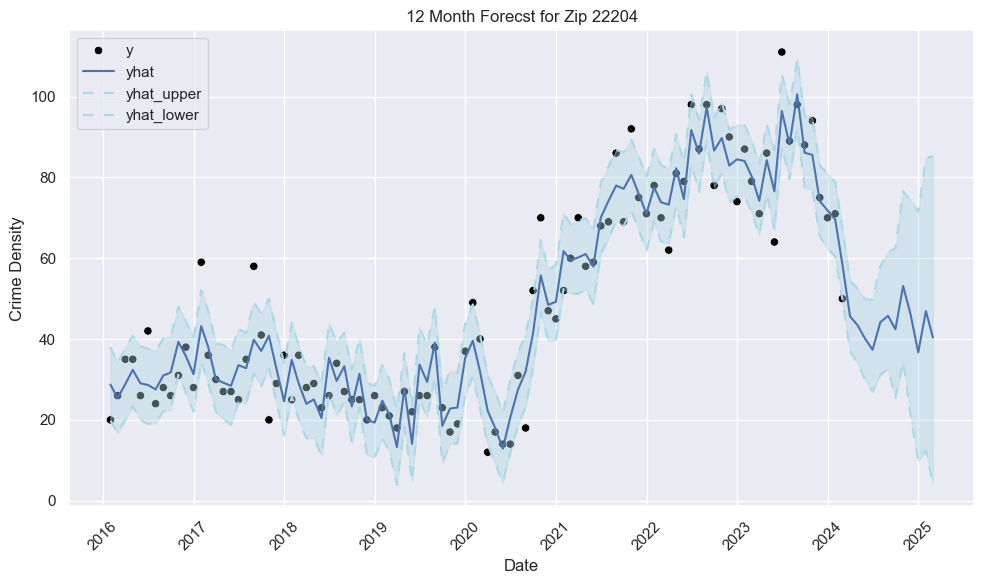

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9572\1375270617.py:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



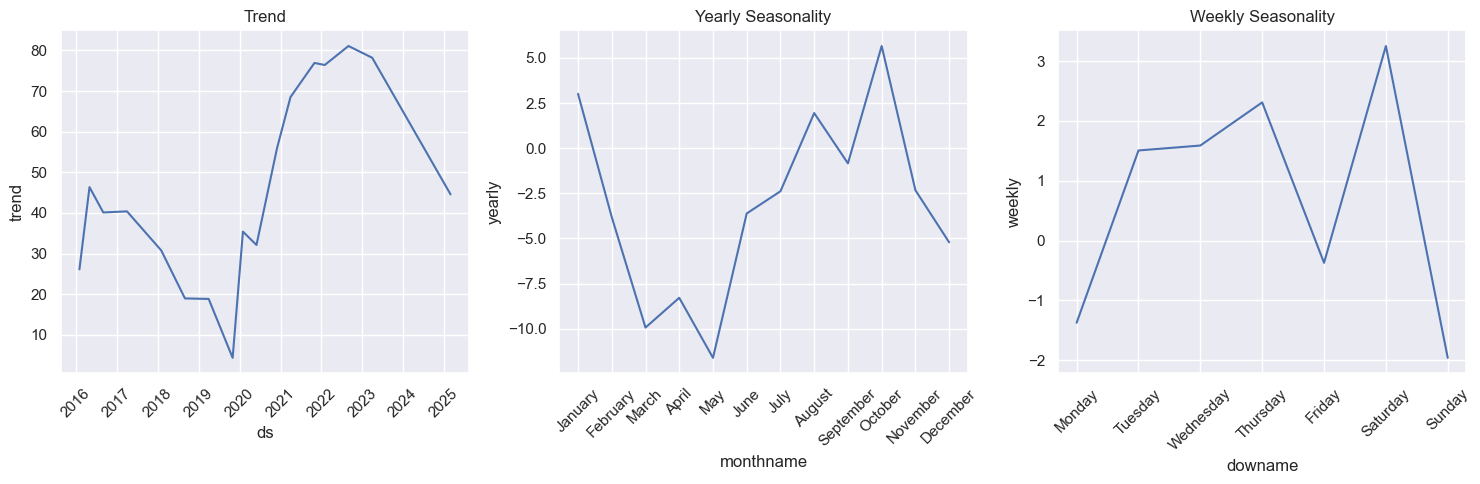

In [190]:
#Forecast zip code 22204
periods = 12
crime = 2
zip_code = '22204'

#Forecast 22204
fcst, fig_forecast, fig_components = prophet_forecast(df, 
                                                # autoregressive_weight=0.5, 
                                                best_params,
                                                zip_code='22204',
                                                crime=2,
                                                periods=12)

# Display the forecast plot
visualize_plots(fcst, zip_code, periods)
plot_trends(fcst)